In [5]:
import pandas as pd
import pymysql
import seaborn as sns
import matplotlib.pyplot as plt

#  Parámetros de conexión
En esta sección establecemos la conexión con las bases de datos, el objetivo de esto es tener acceso a los datos registrados de brillo de las estrellas obtenidos a través del software de reducción de imagen IRAF, la base de datos puede ser un CSV, sin embargo, por las capacidades de SQL de generar columnas dentro de él y obtener y asignar valores para grupos he optado por utilizarlo ahí en SQL.

Para ser específicos, debido a que dentro de IRAF solo obtenemos valores de brillo y radio, así como extraemos la información almacenada dentro de los archivos .fits como objeto, fecha y tiempo de exposición, aún hay columnas las cuales necesitaremos dentro de script de python y son ejecutadas con queries dentro de SQL (estas queries las encontramos dentro de los scripts de MySQL) pero para fines prácticos a continuación explicaremos cuáles columnas fueron agregadas dentro de SQL y qué información contienen.

## Columnas agregadas
Las columnas que agregaremos desde SQL son las siguientes:

### Brillo normalizado
El valor de brillo normalizado se obtiene al dividir el brillo extraído directamente desde IRAF entre el tiempo de exposición, de esta manera obtenemos un valor de brillo por segundo. Este parámetro será utilizado de ahora en adelante como nuestro valor de brillo principal y el brillo proporcionado por IRAF no volverá a ser utilizado.
### Brillo máximo correspondiente
El brillo máximo correspondiente busca el valor de brillo normalizado más alto dentro de un objeto, y es asignado a las estrellas dentro de ese campo, así tenemos en cada fila una referencia directa de la estrella más brillante de ese campo.

### Brillos mínimos y máximos por fecha
El brillo mínimo o máximo por fecha nos dice cuál fue el valor de brillo normalizado más bajo y más alto que fueron registrados en la misma estrella durante esa noche de observación, permitiéndonos conocer un poco el porcentaje de variación por error dentro del telescopio.

### Brillo promedio correspondiente
Este valor se refiere al promedio de Brillos normalizados de las estrellas de un mismo objeto en la misma observación.
     

In [6]:
host = 'localhost'
port = 3306
user = 'root'
password = '12345'
database = 'estrellas_variables'

conn = pymysql.connect(
    host=host,
    port=port,
    user=user,
    password=password,
    db=database
)

# Analisis de datos
A partir de este momento utilizaremos pandas para manejar y tratar los datos, primero importamos toda la base de datos y la nombramos dataframe, ademas el objeto "PG1633+099" es el mismo que "PG1633" por lo que deben estar en el mismo objeto.

In [7]:
general_query = "SELECT * FROM estrellas_registro"
dataframe = pd.read_sql(general_query, conn)
dataframe['Objeto'] = dataframe['Objeto'].replace('PG1633+099', 'PG1633')
dataframe

C:\Users\ch1l1\AppData\Local\Temp\ipykernel_15116\1412858847.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataframe = pd.read_sql(general_query, conn)


,ID,Imagen,Objeto,Filtro,Fecha,Estrella,Brillo,Tamano,Brillo maximo correspondiente,Promedio correspondiente,Max_brillo_fecha,Min_brillo_fecha,tiempo_exp,Brillo_normalizado
0,1,28feb0030o.fits,PG1323-086,B-Johnson+Vacio,2017-02-28,A,699898.0,5.66,29475.0,13739.00,18935.90,16614.80,40.0,17497.40
1,2,28feb0030o.fits,PG1323-086,B-Johnson+Vacio,2017-02-28,B,602852.0,5.61,29475.0,12204.50,15105.80,13982.80,40.0,15071.30
2,3,28feb0030o.fits,PG1323-086,B-Johnson+Vacio,2017-02-28,C,363801.0,5.74,29475.0,7361.09,9121.53,8349.30,40.0,9095.03
3,4,28feb0030o.fits,PG1323-086,B-Johnson+Vacio,2017-02-28,2R,1179000.0,5.64,29475.0,23822.50,29841.80,27250.00,40.0,29475.00
4,5,28feb0031o.fits,PG1323-086,V-Johnson+Vacio,2017-02-28,A,542717.0,5.16,42144.0,33801.70,36181.10,34418.70,15.0,36181.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,469,5081o.fits,PG1633,I-Johnson+Vacio,2006-04-30,A,153321.0,6.46,44433.3,4806.85,5201.65,2869.75,30,5110.70
469,470,5081o.fits,PG1633,I-Johnson+Vacio,2006-04-30,B,1333000.0,5.80,44433.3,41977.40,44970.40,25004.40,30,44433.30
470,471,5081o.fits,PG1633,I-Johnson+Vacio,2006-04-30,C,1107000.0,5.65,44433.3,24582.60,36900.00,3542.55,30,36900.00
471,472,5081o.fits,PG1633,I-Johnson+Vacio,2006-04-30,D,455963.0,5.76,44433.3,6110.12,15198.80,0.00,30,15198.80


## Agregar columnas con python y limpieza de datos.
Necesitaremos las siguientes columnas

### Brillo relativo
Dentro de la astronomía se suele decir que los la información que tiene más valor son los valores relativos, pues estos ofrecen un punto de ventaja en comparación directa, para calcular este brillo relativo basta con dividir el brillo normalizado entre el brillo máximo correspondiente. Obtendremos ahora valores que solo se encuentran entre 0 y 1, sin embargo, eliminaremos los valores 1 y 0, que representan a las estrellas que no van a variar (si observamos al final del proceso que todas las estrellas del campo son clasificadas como variables estas estrellas que son eliminadas como estándar eran variables).
### Variación mínima
La variación mínima es el índice que nos permitirá conocer si una estrella es variable o no lo es basándonos en su cambio secuencial de brillo normalizado, para conocerlo lo calculamos como el promedio de la división del brillo máximo por fecha entre el promedio correspondiente más la división de del brillo mínimo por fecha entre el promedio correspondiente.

In [9]:
dataframe['Brillo relativo'] = dataframe['Brillo_normalizado']/dataframe['Brillo maximo correspondiente']
dataframe['Variacion minima'] = ((dataframe['Max_brillo_fecha']/dataframe['Promedio correspondiente'])+(dataframe['Min_brillo_fecha']/dataframe['Promedio correspondiente']))/2

indices_a_eliminar = dataframe[dataframe['Brillo relativo'] == 1].index
dataframe.drop(indices_a_eliminar, inplace=True)

nuevos_indices_a_eliminar = dataframe[dataframe['Variacion minima'] == 0].index
dataframe.drop(nuevos_indices_a_eliminar, inplace=True)

## Clasificación de estrellas variables.
Comenzaremos organizando cronológicamente dataframe
El algoritmo clasificador comparará cada valor de brillo normalizado con su valor anterior observado si este varía la cantidad mencionada en la columna "Variación mínima", si este umbral es cruzado un porcentaje que debe ser seteado en base a la cantidad de datos (más datos nos permíten un mayor porcentaje y una resultado más estricto).
WARNING. En la base de datos proporcionados los datos, son los datos de calibración del telescopio en campos conocidos por solo tener estrellas estandarés por lo que el porcentaje aquí es reducido a 30% para así poder obtener resultados y continuar con la demostración, sin embargo, buscariamos un porcentaje mayor a 60% para poder clasificar las estrellas como variables, mantenga en mente esto para la sección de resultados.

De esto anterior generaremos un nuevo dataframe que contiene las estrellas ahora clasificadas como estrellas variables.

In [13]:
#Organiza cronológicamente el df
dataframe['Fecha']= pd.to_datetime(dataframe['Fecha'])
dataframe = dataframe.sort_values('Fecha')

#Itera a través de las combinaciones de 'Estrella', 'Filtro' y 'Objeto'
combinaciones = dataframe[['Estrella', 'Filtro', 'Objeto']].drop_duplicates()

# Crear un dataframe vacío para 'Estrellas_Variables' nuevamente
estrellas_variables_list = []

for _, comb in combinaciones.iterrows():
    subset = dataframe[(dataframe['Estrella'] == comb['Estrella']) & 
                   (dataframe['Filtro'] == comb['Filtro']) & 
                   (dataframe['Objeto'] == comb['Objeto'])].copy()

    
    # Calcula el porcentaje de variación en 'Brillo relativo' entre las entradas consecutivas
    subset['Cambio_brillo'] = subset['Brillo relativo'].pct_change().abs()
    
    # Comparar la diferencia con 'Error correspondiente' y contar cuántas veces la diferencia es mayor
    count_dif_mayor_error = (subset['Cambio_brillo'] > subset['Variacion minima']).sum()
    
    # Si más del 30% de las diferencias son mayores que 'Variacion minima', añadir esos datos
    if count_dif_mayor_error / len(subset) > 0.3:
        estrellas_variables_list.append(subset)

# Concatenamos todos los subsets que cumplen con el criterio
estrellas_variables = pd.concat(estrellas_variables_list)

# Limpiamos la columna adicional que creamos
if 'Cambio_brillo' in estrellas_variables.columns:
    estrellas_variables = estrellas_variables.drop(columns=['Cambio_brillo'])
    
estrellas_variables

,ID,Imagen,Objeto,Filtro,Fecha,Estrella,Brillo,Tamano,Brillo maximo correspondiente,Promedio correspondiente,Max_brillo_fecha,Min_brillo_fecha,tiempo_exp,Brillo_normalizado,Brillo relativo,Variacion minima
181,182,2030o.fits,RU149,R-Johnson+Vacio,2006-04-25,A,52898.0,7.03,76847.2,7950.36,5289.80,5289.80,10,5289.80,0.068835,0.665354
197,198,3030o.fits,RU149,R-Johnson+Vacio,2006-04-26,A,51575.0,6.79,75290.3,7950.36,5157.50,5157.50,10,5157.50,0.068502,0.648713
213,214,4030o.fits,RU149,R-Johnson+Vacio,2006-04-29,A,5055.0,6.96,62845.0,7950.36,505.50,505.50,10,505.50,0.008044,0.063582
245,246,5032o.fits,RU149,R-Johnson+Vacio,2006-04-30,A,75692.0,6.32,75333.3,7950.36,5046.13,5046.13,15,5046.13,0.066984,0.634705
157,158,01mar0070o.fits,RU149,R-Johnson+Vacio,2017-03-01,A,76582.0,4.57,224800.0,7950.36,16386.80,15316.40,5.0,15316.40,0.068133,1.993822
117,118,01mar0034o.fits,RU149,R-Johnson+Vacio,2017-03-01,A,81934.0,4.40,243600.0,7950.36,16386.80,15316.40,5.0,16386.80,0.067269,1.993822
370,371,2075o.fits,PG1633,I-Johnson+Vacio,2006-04-25,C,741643.0,5.92,44990.8,24582.60,37082.10,37082.10,20,37082.10,0.824215,1.508469
285,286,2058o.fits,PG1633,I-Johnson+Vacio,2006-04-25,C,700445.0,5.72,45872.1,34128.90,35022.20,35022.20,20,35022.20,0.763475,1.026174
300,301,3044o.fits,PG1633,I-Johnson+Vacio,2006-04-26,C,947712.0,7.04,38466.7,34128.90,37766.70,31590.40,30,31590.40,0.821240,1.016105
330,331,3062o.fits,PG1633,I-Johnson+Vacio,2006-04-26,C,1133000.0,6.31,45433.3,34128.90,37766.70,31590.40,30,37766.70,0.831256,1.016105


## Analisis visual de estrellas variables
Hasta este punto nuestro algoritmo ya ha clasificado las estrellas variables como debería, a continuación se presenta una manera de analizar los resultados.

Buscaremos realizar un análisis visual de las estrellas variables, la manera de realizar esto es observando las fluctuaciones de brillo normalizado en sus diferentes filtros por lo que limpiaremos un pequeño dataframe, y observaremos las estrellas pertenecientes a que objeto son las que aparecen.

In [15]:
variables_visual = estrellas_variables[['Objeto', 'Estrella', 'Filtro', 'Fecha', 'Brillo relativo', 'Variacion minima']].copy()
#Eliminamos los índices donde Variacion minima es 0 debido a que estos no fluctúan.
nuevos_indices_a_eliminar = variables_visual[variables_visual['Variacion minima'] == 0].index
variables_visual.drop(nuevos_indices_a_eliminar, inplace=True)
variables_visual

,Objeto,Estrella,Filtro,Fecha,Brillo relativo,Variacion minima
181,RU149,A,R-Johnson+Vacio,2006-04-25,0.068835,0.665354
197,RU149,A,R-Johnson+Vacio,2006-04-26,0.068502,0.648713
213,RU149,A,R-Johnson+Vacio,2006-04-29,0.008044,0.063582
245,RU149,A,R-Johnson+Vacio,2006-04-30,0.066984,0.634705
157,RU149,A,R-Johnson+Vacio,2017-03-01,0.068133,1.993822
117,RU149,A,R-Johnson+Vacio,2017-03-01,0.067269,1.993822
370,PG1633,C,I-Johnson+Vacio,2006-04-25,0.824215,1.508469
285,PG1633,C,I-Johnson+Vacio,2006-04-25,0.763475,1.026174
300,PG1633,C,I-Johnson+Vacio,2006-04-26,0.821240,1.016105
330,PG1633,C,I-Johnson+Vacio,2006-04-26,0.831256,1.016105


Una vez identificadas las estrellas variables crearemos pequeños bancos de gráficas para poder explicar cada una de estas gráficas. Recordemos que como se menciono anteriormente, los datos utilizados son los de calibración y el umbral para clasificar una estrella variable es demasiado bajo, por lo que, lo que estamos observando es más probable que sean errores tanto en el registro de datos como errores ambientales, sin embargo analizaremos las fluctuaciones como si se tratara de una estrella variable clasificada correctamente.

In [16]:
estrella_C_pg1633 = dataframe[(dataframe['Estrella'] == 'C') & (dataframe['Objeto'] == 'PG1633')]

estrella_2R_pg1633 = dataframe[(dataframe['Estrella'] == '2R') & (dataframe['Objeto'] == 'PG1633')]

estrella_C_ru149 = dataframe[(dataframe['Estrella'] == 'C') & (dataframe['Objeto'] == 'RU149')]
estrella_C_ru149_2006 = estrella_C_ru149[estrella_C_ru149['Fecha'].dt.year == 2006]
estrella_C_ru149_2017 = estrella_C_ru149[estrella_C_ru149['Fecha'].dt.year == 2017]

estrella_149_ru149 = dataframe[(dataframe['Estrella'] == '149') & (dataframe['Objeto'] == 'RU149')]
estrella_149_ru149_2006 = estrella_149_ru149[estrella_149_ru149['Fecha'].dt.year == 2006]
estrella_149_ru149_2017 = estrella_149_ru149[estrella_149_ru149['Fecha'].dt.year == 2017]

estrella_A_ru149 = dataframe[(dataframe['Estrella'] == 'A') & (dataframe['Objeto'] == 'RU149')]
estrella_A_ru149_2006 = estrella_A_ru149[estrella_A_ru149['Fecha'].dt.year == 2006]
estrella_A_ru149_2017 = estrella_A_ru149[estrella_A_ru149['Fecha'].dt.year == 2017]

estrella_A_PG1323 = dataframe[(dataframe['Estrella'] == 'A') & (dataframe['Objeto'] == 'PG1323-086')]
estrella_A_PG1323_2006 = estrella_A_PG1323[estrella_A_PG1323['Fecha'].dt.year == 2006]
estrella_A_PG1323_2017 = estrella_A_PG1323[estrella_A_PG1323['Fecha'].dt.year == 2017]

estrella_B_ru149 = dataframe[(dataframe['Estrella'] == 'B') & (dataframe['Objeto'] == 'RU149')]
estrella_B_ru149_2006 = estrella_B_ru149[estrella_B_ru149['Fecha'].dt.year == 2006]
estrella_B_ru149_2017 = estrella_B_ru149[estrella_B_ru149['Fecha'].dt.year == 2017]

# Análisis de Estrellas Variables propuestas por el algoritmo

## Estrella Principal de pg1633

Text(0.5, 1.0, 'Estrella principal de PG1633')

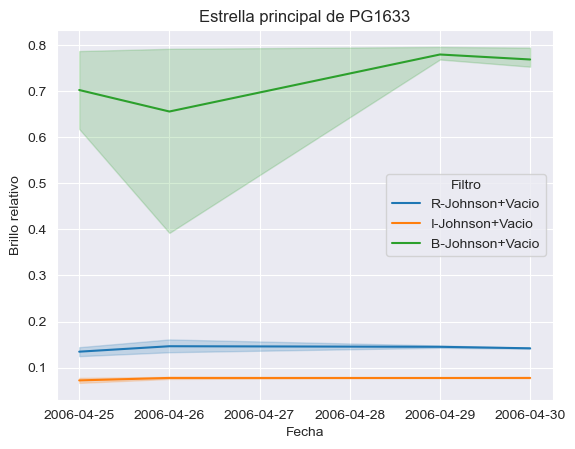

In [17]:
sns.lineplot(data=estrella_2R_pg1633, x='Fecha', y='Brillo relativo', hue='Filtro').set_title('Estrella principal de PG1633')

Como podemos observar esta estrella apenas si presenta variabilidad dentro de sus mediciones, por lo que demuestra la importancia de la verificación visual para encontrar excepciones al algoritmo.

## Estrella C en PG1633

Text(0.5, 1.0, 'Estrella C de PG1633')

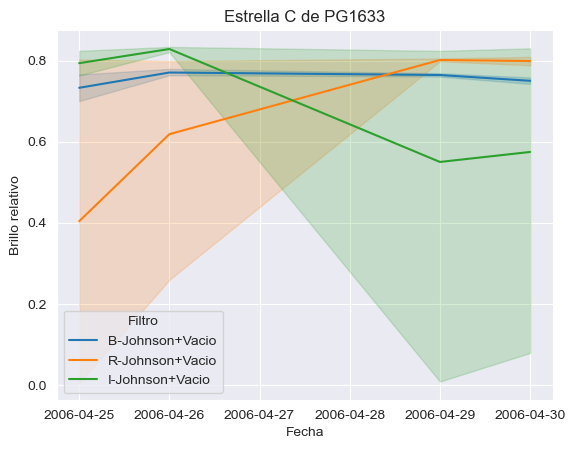

In [19]:
sns.lineplot(data=estrella_C_pg1633, x='Fecha', y='Brillo relativo', hue='Filtro').set_title('Estrella C de PG1633')

Exhibe alta variabilidad en los filtros R-Johnson e I-Johnson, con un pico alrededor del 27 de abril de 2006. Estos picos son indicativos de una estrella variable.

Las fluctuaciones inversas en los filtros I-Johnson y R-Johnson podrían sugerir que la estrella tiene cambios en su espectro de emisión o absorción que son dependientes de la longitud de onda.

Dado que observamos variabilidad en una escala de tiempo de días, esto puede indicar una estrella variable de corto período, como una estrella pulsante o rotante con manchas activas. Como la estrella es más brillante en filtros azules y menos en rojos en ciertos tiempos, podría indicar temperatura variable en la superficie debido a pulsaciones.

## Estrella A en RUBIN149

Text(0.5, 1.0, 'Estrella A de RU149')

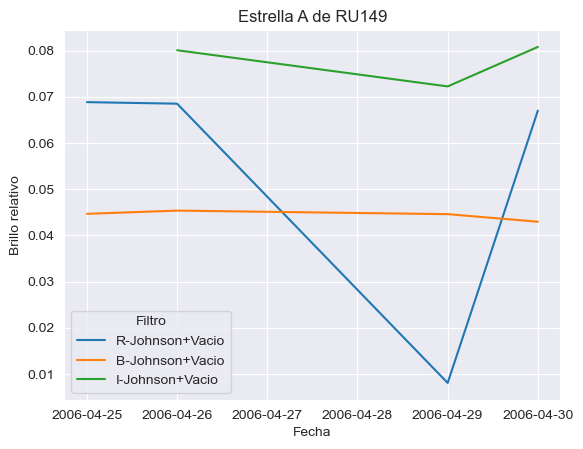

In [20]:
sns.lineplot(data=estrella_A_ru149_2006, x='Fecha', y='Brillo relativo', hue='Filtro').set_title('Estrella A de RU149')

La variabilidad parece ser más pronunciada en el filtro B-Johnson, lo cual puede indicar que cualquier cambio intrínseco en la estrella es más notable en la región azul del espectro. Esto podría sugerir variaciones de temperatura en la superficie de la estrella o cambios en su atmósfera que afectan más la luz azul.

La amplitud de la variación de brillo para los otros filtros no es muy grande, esto podría ser indicativo de una estrella variable de baja amplitud.

## Estrella C en RUBIN 149

Text(0.5, 1.0, 'Estrella C de RU149')

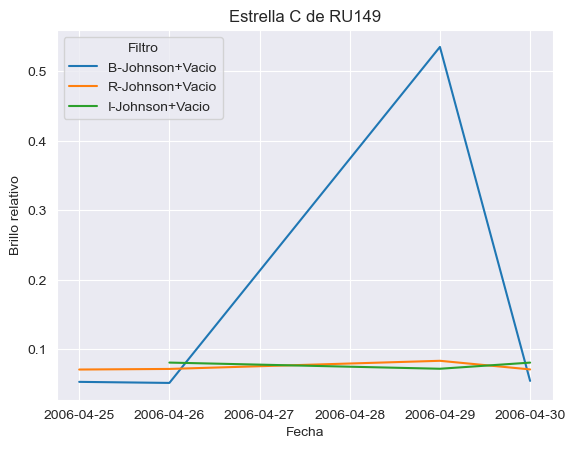

In [21]:
sns.lineplot(data=estrella_C_ru149_2006, x='Fecha', y='Brillo relativo', hue='Filtro').set_title('Estrella C de RU149')

A pesar de que tenemos un pico tan drástico en la variación de brillo relativo el cual  puede indicar un evento particularmente energético en la estrella, como una erupción o una llamarada, especialmente si la estrella es joven o activa o algún objeto interplanetario que este pasando alrededor de este, por la no variación en los otros dos filtros lo más posible es que se trate de un error en los instrumentos de medición o en la extracción y tratamiento de los datos.

## Estrella 149 en RUBIN 149

Text(0.5, 1.0, 'Estrella 149 de RU149')

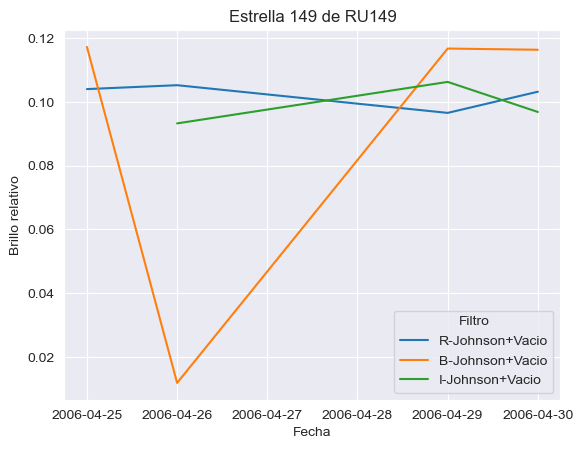

In [22]:
sns.lineplot(data=estrella_149_ru149_2006, x='Fecha', y='Brillo relativo', hue='Filtro').set_title('Estrella 149 de RU149')

La variabilidad detectada podría deberse a procesos físicos dentro de la estrella, como pulsaciones, manchas estelares o llamaradas, que pueden causar cambios en el brillo aparente. también observamos que visualmente la estrella se vuelve más brillante.

Sin embargo, el marcado descenso en un corto periodo de tiempo puede sugerir que estamos viendo un evento aislado o una parte de un ciclo más largo que no se puede identificar completamente con los datos disponibles.